## Detection Significance Examples

Code by: Hafiz Issah, aissah@mines.edu

This notebook uses DAS data from the Bradys Hot Springs (from the Geothermal Data Repository, recorded by the PoroTomo Team), and analyzes detection significance of three small events using template matching with a known event. The standard workflow (without compression) is based on Li and Zhan [2018]. It uses multiple compression types ZFP, wavelets, and SVD at several compression ratios to compare the changes in detection significance due to compression/decompression. Similar analyses are shown for wavelet compression first, then ZFP and finally SVD in the last few cells.

In [1]:
# import h5py
import os, sys
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
import scipy.signal as ss
import zfpy
import operator
import matplotlib

matplotlib.rcParams['figure.figsize'] = (8,6)

sys.path.insert(0, os.path.abspath('..'))

from Functions import eventDTFuncs, general_funcs

The wavelet compression will be Daubechies 5 wavelets. The analyses will be done at 5x, 10x, 20x and 50x compression ratios. The data analyzed will be channels 1500 to 4500. templateSamples indicates range of samples within template file to use as template. Lagmax is the maximum lag calculated in cross-correlations; this was chosen to contain the events of interest.

In [2]:
wavelet='db5'
level=5
templateSamples=[17240, 23256]
channelsToUse=range(1500,4500)
lagmax=28000
samples_per_sec=1000

Here, we load data from hdf5 format files. 

In [3]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data,_=general_funcs.loadBradyHShdf5(file,normalize='no')
data = eventDTFuncs.brady_preprocess(data)
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2,_=general_funcs.loadBradyHShdf5(file,normalize='no')
data2 = eventDTFuncs.brady_preprocess(data2)

The template event and the continuously recorded noise to be compared to the template event are extracted. 

In [4]:
channelsToUse=range(1500,4500)

# template = data[channelsToUse[0]:channelsToUse[-1]]
template = data[::-1][channelsToUse[0]:channelsToUse[-1]]
filtered_template = general_funcs.frequency_filter(template, [1, 15], "bandpass", 5, 1000)
filtered_template = filtered_template[:, templateSamples[0] : templateSamples[1]]
template = template[:, templateSamples[0] : templateSamples[1]]

maxes = np.max(filtered_template, axis=1) 
filtered_template = filtered_template/maxes[:,np.newaxis]

maxes = np.max(template, axis=1) 
template = template/maxes[:,np.newaxis]

signalToUse = np.append(data[:, 24976:], data2, axis=1)
signalToUse = signalToUse[::-1][channelsToUse[0]:channelsToUse[-1]]
# signalToUse = signalToUse[channelsToUse[0]:channelsToUse[-1]]
# means = np.mean(signalToUse, axis=1)
# signalToUse = signalToUse - means[:,np.newaxis]
filtered_signalToUse = general_funcs.frequency_filter(signalToUse, [1, 15], "bandpass", 5, 1000)
maxes = np.max(filtered_signalToUse, axis=1) 
filtered_signalToUse = filtered_signalToUse/maxes[:,np.newaxis]

maxes = np.max(signalToUse, axis=1) 
signalToUse = signalToUse/maxes[:,np.newaxis]

lagmax = len(signalToUse[0]) - len(template[0])

Plot template

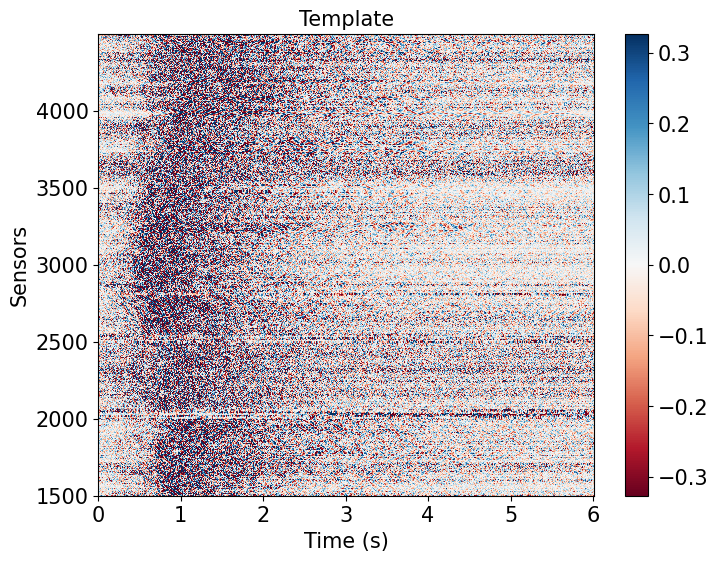

In [5]:
fsize=15
pdata=template # [1900:3900]
fig2 = plt.figure(figsize=(8, 6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, channelsToUse[0],channelsToUse[-1]))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (s)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Template',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

Plot the continuously recorded passive data.

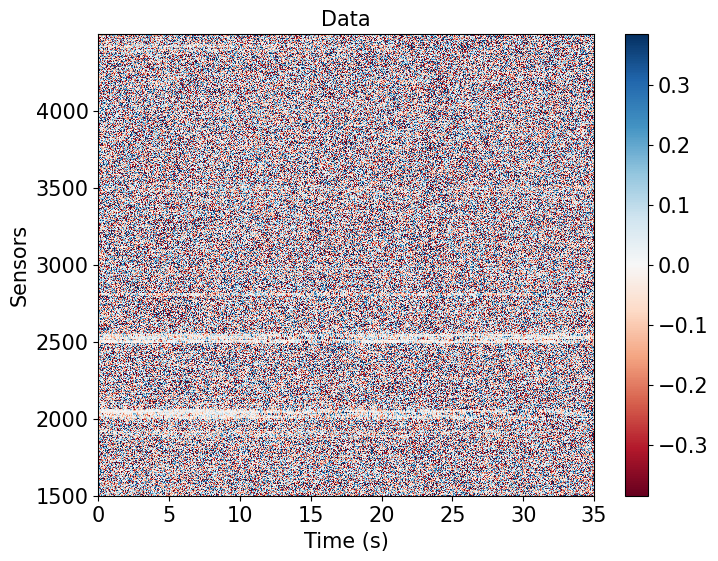

In [6]:
fsize=15
pdata=signalToUse #[1900:3900]
fig2 = plt.figure(figsize=(8, 6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, channelsToUse[0],channelsToUse[-1]))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (s)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Data',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

Do template matching (normalized cross-correlations) for each channel's passive data with its template.

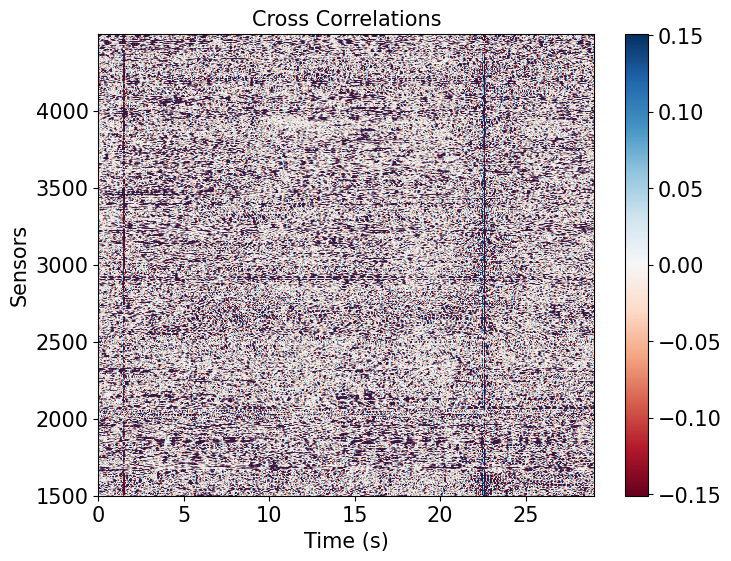

In [7]:
lagmax = len(signalToUse[0]) - len(template[0])
cc = general_funcs.crosscorrelate_channels(filtered_signalToUse, filtered_template, lagmax, stacked="no")

fsize=15
pdata=cc #[1900:3900]
fig2 = plt.figure(figsize=(8, 6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, channelsToUse[0],channelsToUse[-1]))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (s)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Cross Correlations',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

Calculate the detection significance of these cross-correlations at each point in time. 

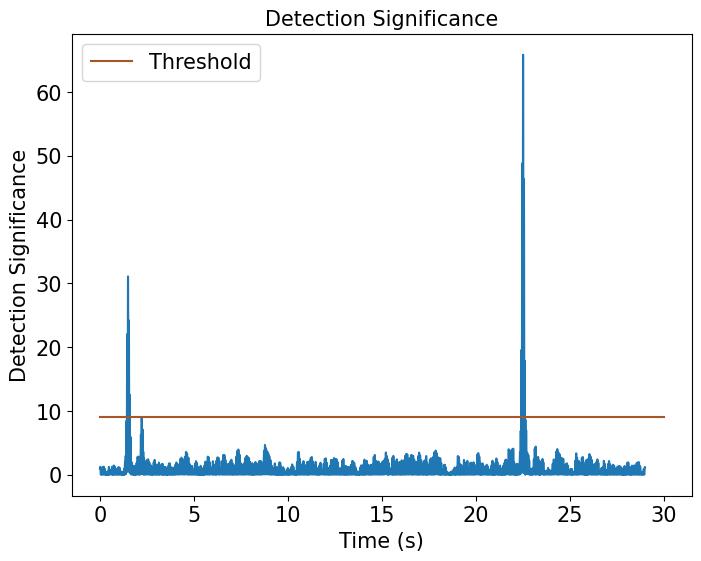

In [8]:
tm = np.mean(cc, axis=0)
detection_sig = eventDTFuncs.find_detection_significance(tm)
time = [a/samples_per_sec for a in range(len(tm))]
plt.figure(figsize=(8, 6))
plt.plot(time, abs(detection_sig))
plt.plot([0,30],[9,9], '#a65628',label="Threshold")
fsize=15
plt.ylabel('Detection Significance',fontsize=fsize)
plt.xlabel('Time (s)',fontsize=fsize)
plt.title('Detection Significance',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.legend(fontsize=fsize)

### Wavelet compression analysis

Carry out the compression then decompression using 2D wavelet transforms for various compression ratios, then do the template matching.

In [9]:
timeLag=np.linspace(0,lagmax/samples_per_sec,lagmax)
compression_ratios=[5,10,20,50,100]
template_matching_uncompressed = cc
averageAcrossChannels_2dw=np.array([np.mean(template_matching_uncompressed, axis=0)])
#averageAcrossChannels_1dw=np.empty((len(compression_ratios)+1, lagmax))
for comp_ratio in compression_ratios:
    chosen_channels_signal= signalToUse #[channelsToUse]
    chosen_channels_template = template #[channelsToUse]
    decompressed_signal, _=general_funcs.compressReconstruct_wavelets(chosen_channels_signal, mode="2D", wavelet=wavelet, lvl=level, compressionFactor=comp_ratio)
    decompressed_template, _=general_funcs.compressReconstruct_wavelets(chosen_channels_template, mode="2D", wavelet=wavelet, lvl=level, compressionFactor=comp_ratio)
    decompressed_signal = general_funcs.frequency_filter(decompressed_signal, [1, 15], "bandpass", 5, 1000)
    decompressed_template = general_funcs.frequency_filter(decompressed_template, [1, 15], "bandpass", 5, 1000)
    #template_matching = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="yes")
    if comp_ratio == 50:
        tm_50_wl = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="no")
        template_matching = np.mean(tm_50_wl, axis=0)
    elif comp_ratio == 100:
        tm_100_wl = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="no")
        template_matching = np.mean(tm_100_wl, axis=0)
    else:
        template_matching = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="yes")

    averageAcrossChannels_2dw=np.append(averageAcrossChannels_2dw, template_matching[:lagmax+1][np.newaxis], axis=0)

Visualize the wavelet-compressed template matching.

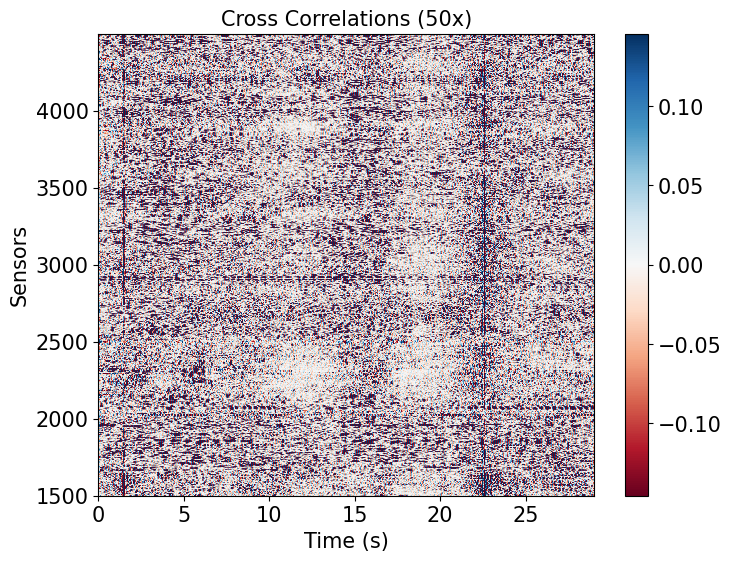

In [10]:
fsize=15
pdata=tm_50_wl #[1900:3900]
fig2 = plt.figure(figsize=(8, 6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, channelsToUse[0],channelsToUse[-1]))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (s)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Cross Correlations (50x)',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

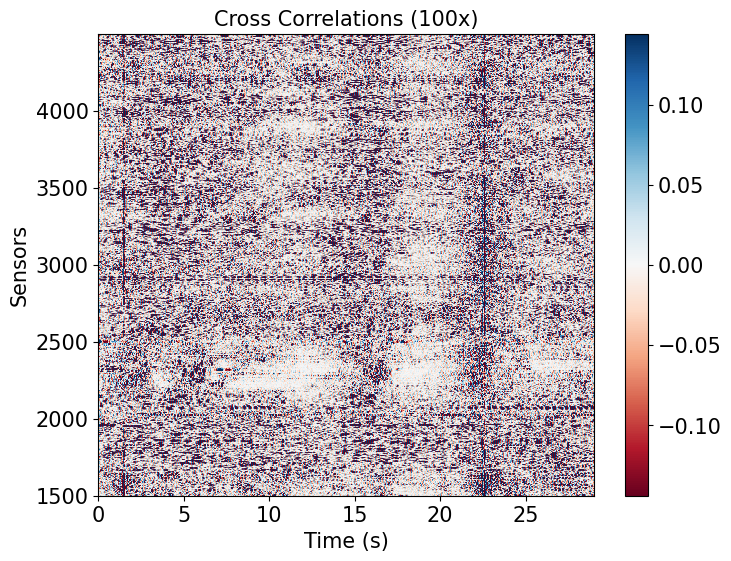

In [11]:
fsize=15
pdata=tm_100_wl #[1900:3900]
fig2 = plt.figure(figsize=(8, 6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, channelsToUse[0],channelsToUse[-1]))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (s)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Cross Correlations (100x)',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

Plot the average across channels of the template matching results for each wavelet compression ratio.

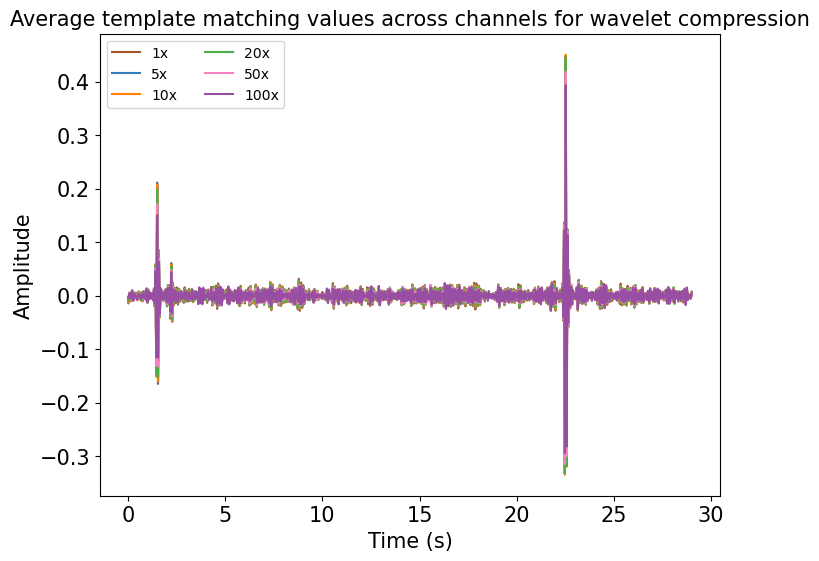

In [12]:
fsize = 15
startfrom=0
rightBeforeTemplate=lagmax
plt.figure(figsize=(8, 6))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[0][startfrom:rightBeforeTemplate],'#a65628', label="1x") #'Uncompressed')
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[1][startfrom:rightBeforeTemplate],'#377eb8', label=str(compression_ratios[0]) + "x") #"Comp ratio " + str(compression_ratios[0]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[2][startfrom:rightBeforeTemplate],'#ff7f00', label=str(compression_ratios[1]) + "x") #"Comp ratio " + str(compression_ratios[1]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[3][startfrom:rightBeforeTemplate],'#4daf4a', label=str(compression_ratios[2]) + "x") #"Comp ratio " + str(compression_ratios[2]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[4][startfrom:rightBeforeTemplate],'#f781bf', label=str(compression_ratios[3]) + "x") #"Comp ratio " + str(compression_ratios[3]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[5][startfrom:rightBeforeTemplate],'#984ea3', label=str(compression_ratios[4]) + "x") #"Comp ratio " + str(100))
fsize=15
plt.ylabel('Amplitude',fontsize=fsize)
plt.xlabel('Time (s)',fontsize=fsize)
plt.title('Average template matching values across channels for wavelet compression',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
fsize = 10
plt.legend(ncol=2, fontsize=fsize)

The following plot is the same as the immediate one above without the plot for the 100x case.

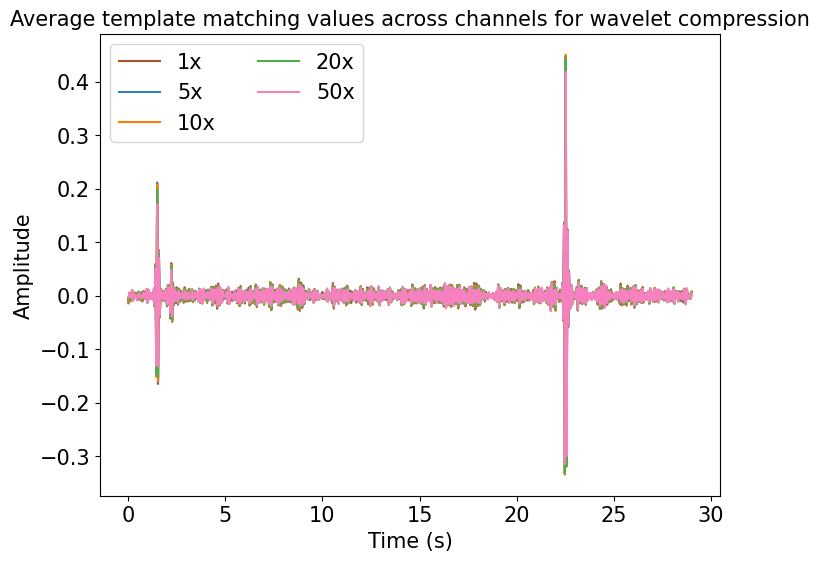

In [13]:
fsize = 15
startfrom=0
rightBeforeTemplate=lagmax
plt.figure(figsize=(8, 6))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[0][startfrom:rightBeforeTemplate],'#a65628', label="1x") #'Uncompressed')
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[1][startfrom:rightBeforeTemplate],'#377eb8', label=str(compression_ratios[0]) + "x") #"Comp ratio " + str(compression_ratios[0]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[2][startfrom:rightBeforeTemplate],'#ff7f00', label=str(compression_ratios[1]) + "x") #"Comp ratio " + str(compression_ratios[1]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[3][startfrom:rightBeforeTemplate],'#4daf4a', label=str(compression_ratios[2]) + "x") #"Comp ratio " + str(compression_ratios[2]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],averageAcrossChannels_2dw[4][startfrom:rightBeforeTemplate],'#f781bf', label=str(compression_ratios[3]) + "x") #"Comp ratio " + str(compression_ratios[3]))
fsize=15
plt.ylabel('Amplitude',fontsize=fsize)
plt.xlabel('Time (s)',fontsize=fsize)
plt.title('Average template matching values across channels for wavelet compression',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.legend(ncol=2, fontsize=fsize)

For each wavelet compression ratio, plot the envelope of the average across channels of the template matching. 

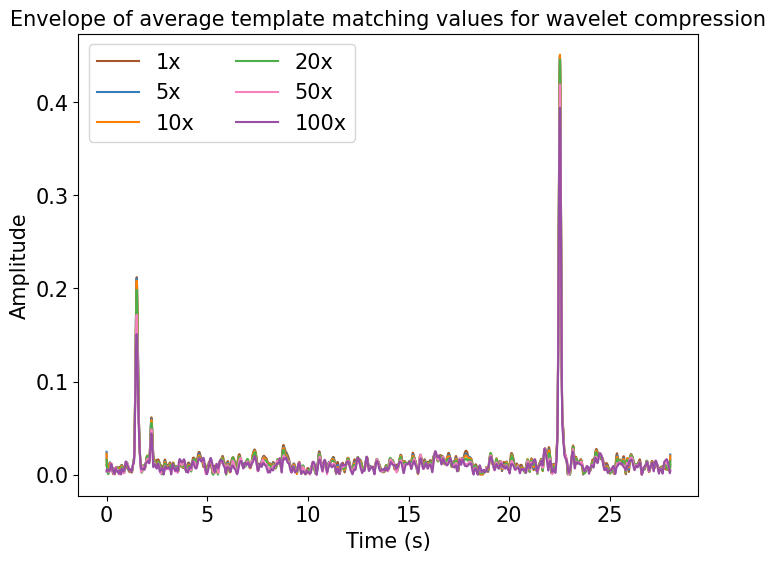

In [14]:
startfrom=0
rightBeforeTemplate=28000
plt.figure(figsize=(8, 6))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[0][startfrom:rightBeforeTemplate])),'#a65628', label="1x") #'Uncompressed')
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[1][startfrom:rightBeforeTemplate])),'#377eb8', label=str(compression_ratios[0]) + "x") #"Comp ratio " + str(compression_ratios[0]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[2][startfrom:rightBeforeTemplate])),'#ff7f00', label=str(compression_ratios[1]) + "x") #"Comp ratio " + str(compression_ratios[1]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[3][startfrom:rightBeforeTemplate])),'#4daf4a', label=str(compression_ratios[2]) + "x") #"Comp ratio " + str(compression_ratios[2]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[4][startfrom:rightBeforeTemplate])),'#f781bf', label=str(compression_ratios[3]) + "x") #"Comp ratio " + str(compression_ratios[3]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[5][startfrom:rightBeforeTemplate])),'#984ea3', label=str(compression_ratios[4]) + "x") #"Comp ratio " + str(100))
fsize=15
plt.ylabel('Amplitude',fontsize=fsize)
plt.xlabel('Time (s)',fontsize=fsize)
plt.title('Envelope of average template matching values for wavelet compression',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.legend(ncol=2, fontsize=fsize)

The following plot is the same as the immediate one above without the plot for the 100x case.

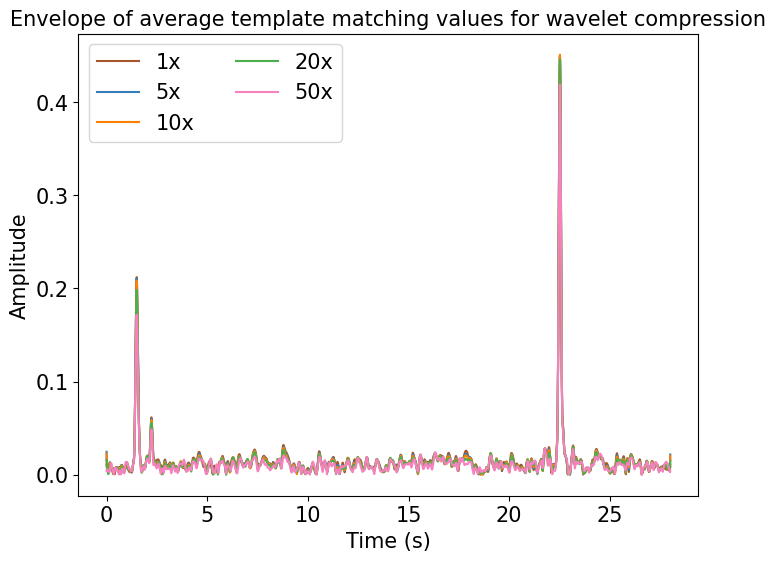

In [15]:
startfrom=0
rightBeforeTemplate=28000
plt.figure(figsize=(8, 6))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[0][startfrom:rightBeforeTemplate])),'#a65628', label="1x") #'Uncompressed')
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[1][startfrom:rightBeforeTemplate])),'#377eb8', label=str(compression_ratios[0]) + "x") #"Comp ratio " + str(compression_ratios[0]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[2][startfrom:rightBeforeTemplate])),'#ff7f00', label=str(compression_ratios[1]) + "x") #"Comp ratio " + str(compression_ratios[1]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[3][startfrom:rightBeforeTemplate])),'#4daf4a', label=str(compression_ratios[2]) + "x") #"Comp ratio " + str(compression_ratios[2]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_2dw[4][startfrom:rightBeforeTemplate])),'#f781bf', label=str(compression_ratios[3]) + "x") #"Comp ratio " + str(compression_ratios[3]))
fsize=15
plt.ylabel('Amplitude',fontsize=fsize)
plt.xlabel('Time (s)',fontsize=fsize)
plt.title('Envelope of average template matching values for wavelet compression',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
# fsize = 10
plt.legend(ncol = 2, fontsize=fsize)

For each wavelet compression ratio, calculate and visualize the detection significance of the three peak events from the previous plot. Event 1 is the mid-size event, event 2 is the small event, and event 3 is the large event. 

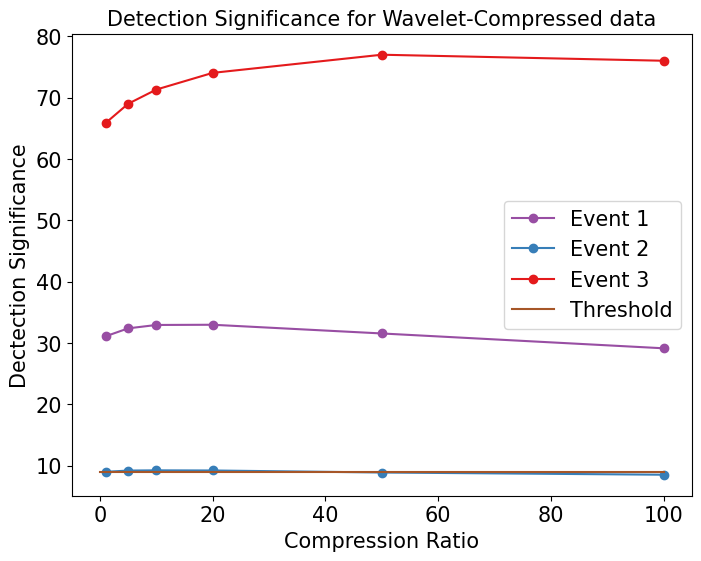

In [16]:
compression_ratios=[5,10,20,50,100]
colors=["#984ea3","#377eb8","#e41a1c"]
peakWindows=[[1200,1900],[1900,2500],[22000,23000]]
detectionSigs=np.empty((1,len(peakWindows)))
for a in averageAcrossChannels_2dw:
    med=np.median(a)
    mad=np.median(abs(a-np.median(a)))
    dss=[]
    for b in peakWindows:
        ds=(max(a[b[0]:b[1]])-med)/mad
        dss.append(ds)
    detectionSigs=np.append(detectionSigs, np.array([dss]), axis=0)
detectionSigs=detectionSigs[1:]

fsize = 15
plt.figure(figsize=(8, 6))
plt.plot([1]+compression_ratios,detectionSigs[:,0], '#984ea3', marker='o', label="Event 1")
plt.plot([1]+compression_ratios,detectionSigs[:,1], '#377eb8', marker='o', label="Event 2")
plt.plot([1]+compression_ratios,detectionSigs[:,2], '#e41a1c', marker='o', label="Event 3")
plt.plot([0,100],[9,9], '#a65628',label="Threshold")
plt.ylabel('Dectection Significance',fontsize=fsize)
plt.xlabel('Compression Ratio',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
# plt.title('Detection Significance with respect to Compression Ratio',fontsize=fsize)
plt.title('Detection Significance for Wavelet-Compressed data',fontsize=fsize)
# fsize = 10
plt.legend(fontsize=fsize)  

Same visualization, just with compression oup to 50x. 

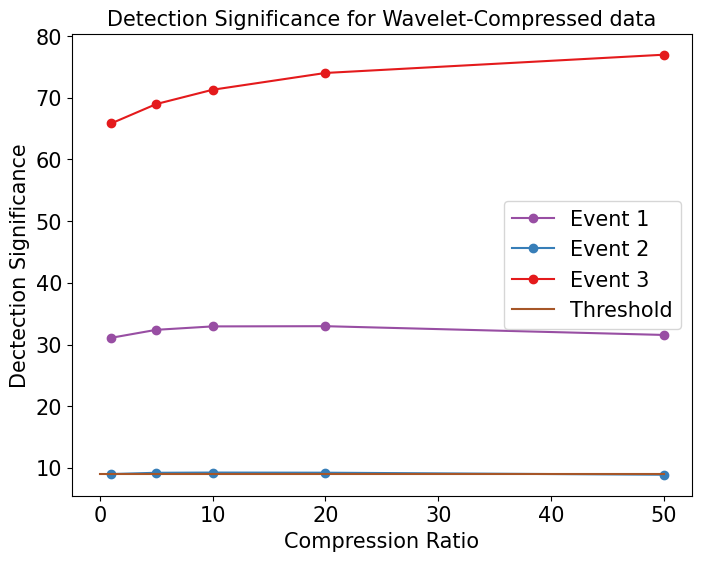

In [17]:
compression_ratios=[5,10,20,50,100]
colors=["#984ea3","#377eb8","#e41a1c"]
peakWindows=[[1200,1900],[1900,2500],[22000,23000]]
detectionSigs=np.empty((1,len(peakWindows)))
for a in averageAcrossChannels_2dw:
    med=np.median(a)
    mad=np.median(abs(a-np.median(a)))
    dss=[]
    for b in peakWindows:
        ds=(max(a[b[0]:b[1]])-med)/mad
        dss.append(ds)
    detectionSigs=np.append(detectionSigs, np.array([dss]), axis=0)
detectionSigs=detectionSigs[1:]
fsize = 15
plt.figure(figsize=(8, 6))
plt.plot([1]+compression_ratios[:-1],detectionSigs[:,0][:-1], '#984ea3', marker='o', label="Event 1")
plt.plot([1]+compression_ratios[:-1],detectionSigs[:,1][:-1], '#377eb8', marker='o', label="Event 2")
plt.plot([1]+compression_ratios[:-1],detectionSigs[:,2][:-1], '#e41a1c', marker='o', label="Event 3")
plt.plot([0,50],[9,9], '#a65628',label="Threshold")
plt.ylabel('Dectection Significance',fontsize=fsize)
plt.xlabel('Compression Ratio',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
# plt.title('Detection Significance with respect to Compression Ratio',fontsize=fsize)
plt.title('Detection Significance for Wavelet-Compressed data',fontsize=fsize)
plt.legend(fontsize=fsize)  

## ZFP compression analysis

Carry out the compression then decompression using ZFP compression for various precision levels, then do the template matching. The compression ratios here are determined by the various levels of precision that can be specified.

In [18]:
precisions = [6,5,4,3,2]
timeLag=np.linspace(0,lagmax/samples_per_sec,lagmax)

averageAcrossChannels_zfp=np.array([np.mean(template_matching_uncompressed, axis=0)])
sizes=[signalToUse.nbytes]
for prec in precisions:
    compressed_data = zfpy.compress_numpy(signalToUse, precision=prec)
    decompressed_signal=zfpy.decompress_numpy(compressed_data)
    size=len(compressed_data)
    sizes.append(size)
    compressed_data = zfpy.compress_numpy(template, precision=prec)
    decompressed_template=zfpy.decompress_numpy(compressed_data)
    decompressed_signal = general_funcs.frequency_filter(decompressed_signal, [1, 15], "bandpass", 5, 1000)
    decompressed_template = general_funcs.frequency_filter(decompressed_template, [1, 15], "bandpass", 5, 1000)
    chosen_channels_signal= decompressed_signal #[channelsToUse]
    chosen_channels_template = decompressed_template#[channelsToUse]
    # template_matching = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="yes")
    if prec == precisions[-1]:
        tm_zfp = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="no")
        template_matching = np.mean(tm_zfp, axis=0)
    else:
        template_matching = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="yes")

    averageAcrossChannels_zfp=np.append(averageAcrossChannels_zfp, template_matching[np.newaxis], axis=0)

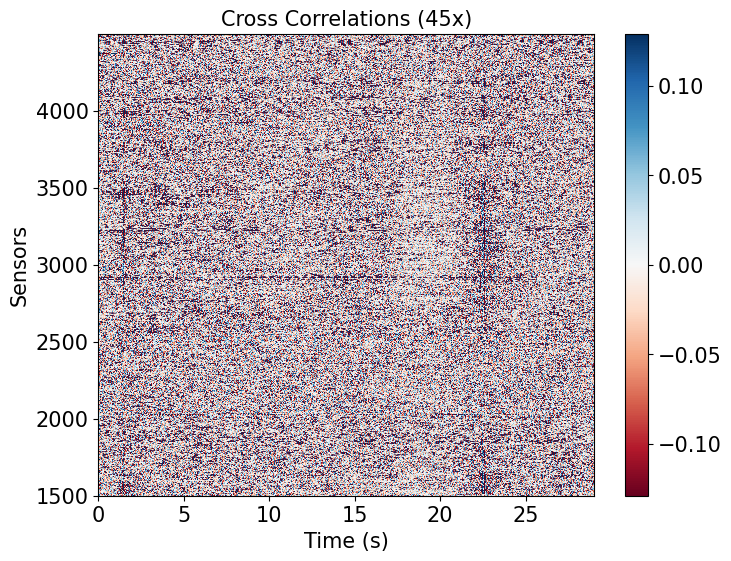

In [19]:
fsize=15
pdata=tm_zfp #[1900:3900]
fig2 = plt.figure(figsize=(8, 6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, channelsToUse[0],channelsToUse[-1]))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (s)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Cross Correlations (' + str(int(sizes[0]/sizes[5])) +'x)',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

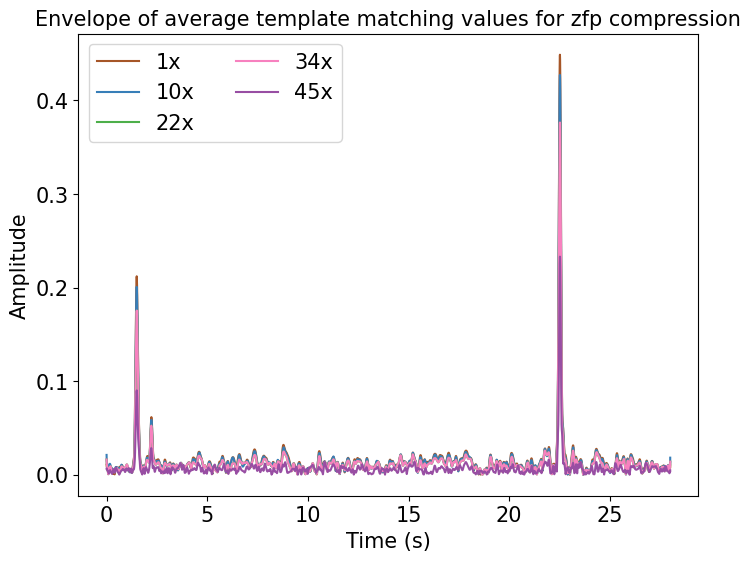

In [20]:
startfrom=0
rightBeforeTemplate=28000
plt.figure(figsize=(8, 6))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_zfp[0][startfrom:rightBeforeTemplate])),'#a65628', label="1x") #'Uncompressed')
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_zfp[1][startfrom:rightBeforeTemplate])),'#377eb8', label=str(int(sizes[0]/sizes[1])) + "x") #Comp ratio " + str(int(sizes[0]/sizes[1])))
# plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_zfp[2][startfrom:rightBeforeTemplate])),'#ff7f00', label=str(int(sizes[0]/sizes[2])) + "x") #"Comp ratio " + str(int(sizes[0]/sizes[2])))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_zfp[3][startfrom:rightBeforeTemplate])),'#4daf4a', label=str(int(sizes[0]/sizes[3])) + "x") #"Comp ratio " + str(int(sizes[0]/sizes[3])))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_zfp[3][startfrom:rightBeforeTemplate])),'#f781bf', label=str(int(sizes[0]/sizes[4])) + "x") #"Comp ratio " + str(int(sizes[0]/sizes[4])))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_zfp[5][startfrom:rightBeforeTemplate])),'#984ea3', label=str(int(sizes[0]/sizes[5])) + "x") #"Comp ratio " + str(int(sizes[0]/sizes[5])))
fsize=15
plt.ylabel('Amplitude',fontsize=fsize)
plt.xlabel('Time (s)',fontsize=fsize)
# plt.title('Peak amplitude variation with compression',fontsize=fsize)
plt.title('Envelope of average template matching values for zfp compression',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.legend(ncol=2, fontsize=fsize)

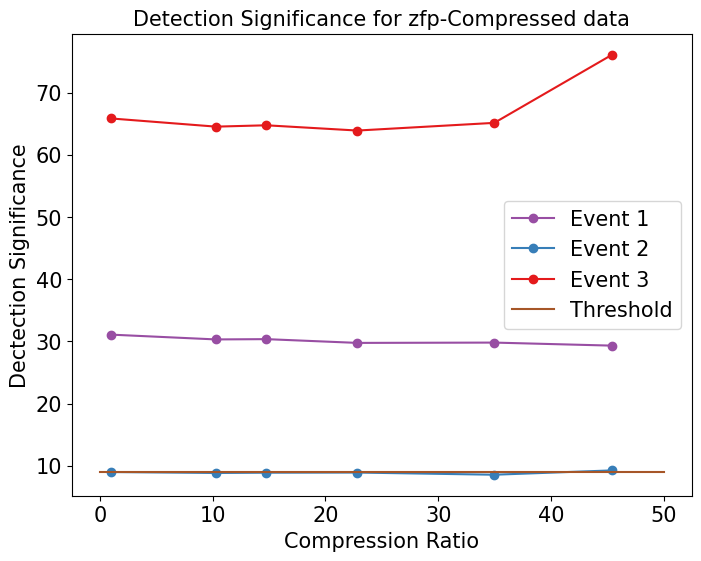

In [21]:
peakWindows=[[1200,1900],[1900,2500],[22000,23000]]
detectionSigs=np.empty((1,len(peakWindows)))
for a in averageAcrossChannels_zfp:
    med=np.median(a)
    mad=np.median(abs(a-np.median(a)))
    dss=[]
    for b in peakWindows:
        ds=(max(a[b[0]:b[1]])-med)/mad
        dss.append(ds)
    detectionSigs=np.append(detectionSigs, np.array([dss]), axis=0)
detectionSigs=detectionSigs[1:]

plt.figure(figsize=(8, 6))
compression_ratios_zfp=[sizes[0]/a for a in sizes]
plt.plot(compression_ratios_zfp,detectionSigs[:,0], '#984ea3', marker='o', label="Event 1")
plt.plot(compression_ratios_zfp,detectionSigs[:,1], '#377eb8', marker='o', label="Event 2")
plt.plot(compression_ratios_zfp,detectionSigs[:,2], '#e41a1c', marker='o', label="Event 3")
plt.plot([0,50],[9,9], '#a65628',label="Threshold")
plt.ylabel('Dectection Significance',fontsize=fsize)
plt.xlabel('Compression Ratio',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
# plt.title('Detection Significance with respect to Compression Ratio',fontsize=fsize)
plt.title('Detection Significance for zfp-Compressed data',fontsize=fsize)
plt.legend(fontsize=fsize)  

## SVD Compression Analysis

Carry out the compression then decompression using SVD (randomized) for various compression ratios, then do the template matching. 

In [22]:
def randomized_SVD_comp_decomp(data, compFactor):
    from sklearn.utils.extmath import randomized_svd

    rows, columns = data.shape
    approxRank = int((rows * columns) / (compFactor * (rows + columns)))
    # U, S, Vt = la.svd(data)
    U, S, Vt = randomized_svd(data, n_components=approxRank)
    recon = U @ np.diag(S) @ Vt
    # sv = np.dot(np.diag(S), Vt)
    # recon = np.dot(U, sv)
    return recon


timeLag=np.linspace(0,lagmax/samples_per_sec,lagmax)
#averageAcrossChannels=np.array([range(lagmax)])
averageAcrossChannels_svd=np.array([np.mean(template_matching_uncompressed, axis=0)])
for comp_ratio in compression_ratios:
    templateMatching=np.array([range(lagmax)])
    decompressed_signal=randomized_SVD_comp_decomp(signalToUse, comp_ratio)
    decompressed_template=randomized_SVD_comp_decomp(template, comp_ratio)
    decompressed_signal = general_funcs.frequency_filter(decompressed_signal, [1, 15], "bandpass", 5, 1000)
    decompressed_template = general_funcs.frequency_filter(decompressed_template, [1, 15], "bandpass", 5, 1000)
    
    if comp_ratio == 50:
        tm_50_svd = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="no")
        template_matching = np.mean(tm_50_svd, axis=0)
    elif comp_ratio == 100:
        tm_100_svd = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="no")
        template_matching = np.mean(tm_100_svd, axis=0)
    else:
        template_matching = general_funcs.crosscorrelate_channels(decompressed_signal, decompressed_template, lagmax, stacked="yes")
    
    averageAcrossChannels_svd=np.append(averageAcrossChannels_svd, template_matching[np.newaxis], axis=0)


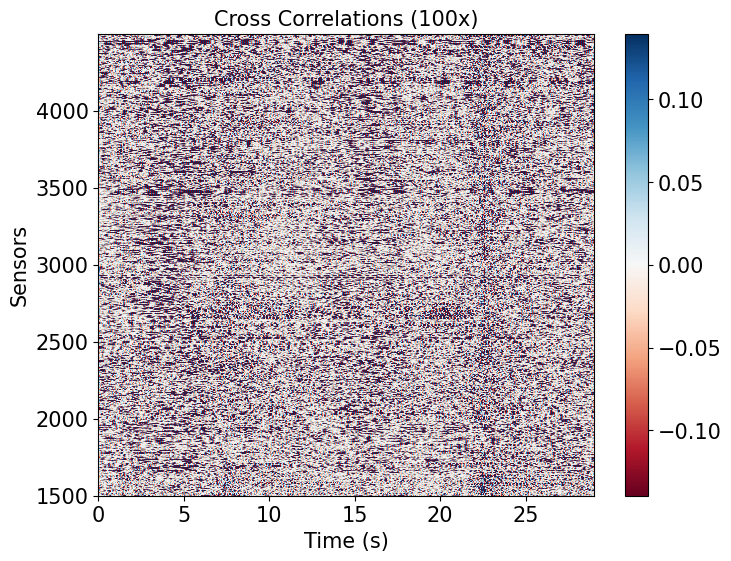

In [23]:
fsize=15
pdata=tm_100_svd #[1900:3900]
fig2 = plt.figure(figsize=(8, 6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, channelsToUse[0],channelsToUse[-1]))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (s)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Cross Correlations (100x)',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

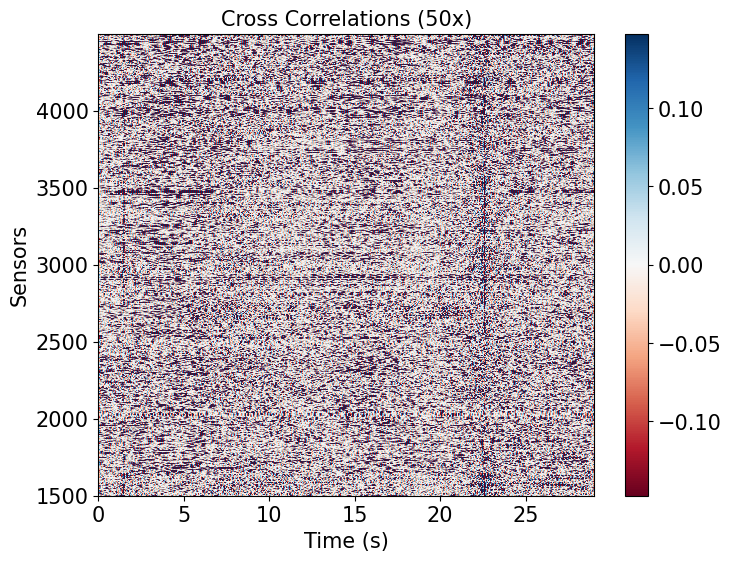

In [24]:
fsize=15
pdata=tm_50_svd #[1900:3900]
fig2 = plt.figure(figsize=(8, 6))
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, channelsToUse[0],channelsToUse[-1]))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (s)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Cross Correlations (50x)',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

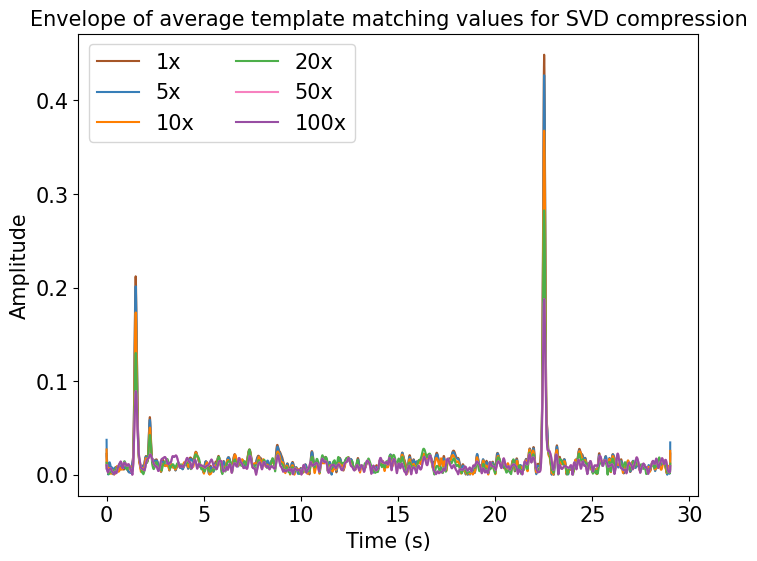

In [25]:
startfrom=0
rightBeforeTemplate=lagmax #28000
plt.figure(figsize=(8, 6))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[0][startfrom:rightBeforeTemplate])),'#a65628', label="1x") #'Uncompressed')
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[1][startfrom:rightBeforeTemplate])),'#377eb8', label=str(compression_ratios[0]) + "x") #"Comp ratio " + str(compression_ratios[0]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[2][startfrom:rightBeforeTemplate])),'#ff7f00', label=str(compression_ratios[1]) + "x") #"Comp ratio " + str(compression_ratios[1]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[3][startfrom:rightBeforeTemplate])),'#4daf4a', label=str(compression_ratios[2]) + "x") #"Comp ratio " + str(compression_ratios[2]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[4][startfrom:rightBeforeTemplate])),'#f781bf', label=str(compression_ratios[3]) + "x") #"Comp ratio " + str(compression_ratios[3]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[4][startfrom:rightBeforeTemplate])),'#984ea3', label=str(compression_ratios[4]) + "x") #"Comp ratio " + str(compression_ratios[3]))
fsize=15
plt.ylabel('Amplitude',fontsize=fsize)
plt.xlabel('Time (s)',fontsize=fsize)
# plt.title('Peak amplitude variation with compression',fontsize=fsize)
plt.title('Envelope of average template matching values for SVD compression',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.legend(ncol=2, fontsize=fsize)

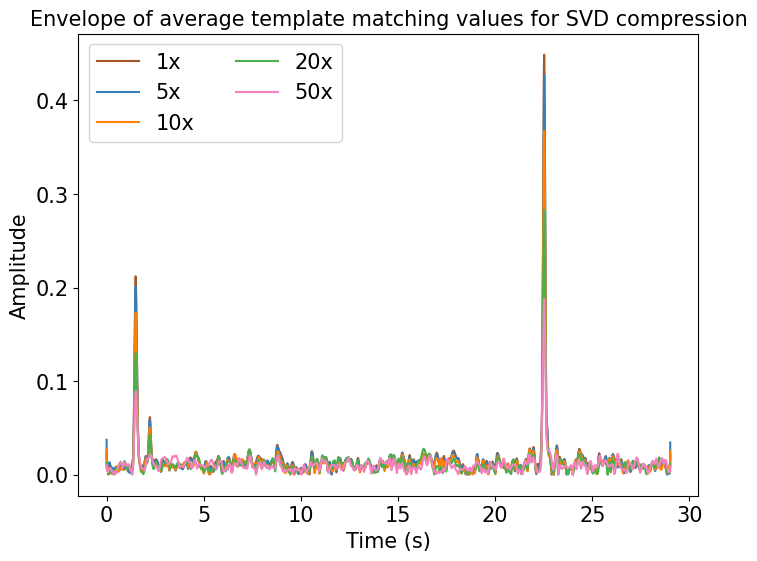

In [26]:
startfrom=0
rightBeforeTemplate=lagmax #28000
plt.figure(figsize=(8, 6))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[0][startfrom:rightBeforeTemplate])),'#a65628', label="1x") #'Uncompressed')
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[1][startfrom:rightBeforeTemplate])),'#377eb8', label=str(compression_ratios[0]) + "x") #"Comp ratio " + str(compression_ratios[0]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[2][startfrom:rightBeforeTemplate])),'#ff7f00', label=str(compression_ratios[1]) + "x") #"Comp ratio " + str(compression_ratios[1]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[3][startfrom:rightBeforeTemplate])),'#4daf4a', label=str(compression_ratios[2]) + "x") #"Comp ratio " + str(compression_ratios[2]))
plt.plot(timeLag[startfrom:rightBeforeTemplate],np.abs(ss.hilbert(averageAcrossChannels_svd[4][startfrom:rightBeforeTemplate])),'#f781bf', label=str(compression_ratios[3]) + "x") #"Comp ratio " + str(compression_ratios[3]))
fsize=15
plt.ylabel('Amplitude',fontsize=fsize)
plt.xlabel('Time (s)',fontsize=fsize)
plt.title('Envelope of average template matching values for SVD compression',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.legend(ncol=2, fontsize=fsize)

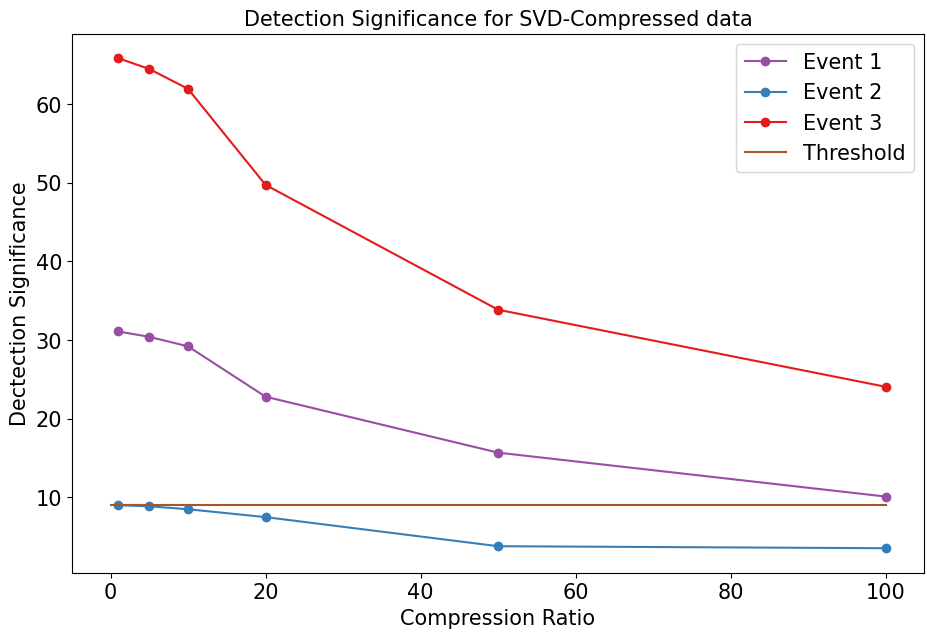

In [27]:
peakWindows=[[1200,1900],[1900,2500],[22000,23000]]
detectionSigs=np.empty((1,len(peakWindows)))
for a in averageAcrossChannels_svd:
    med=np.median(a)
    mad=np.median(abs(a-np.median(a)))
    dss=[]
    for b in peakWindows:
        ds=(max(a[b[0]:b[1]])-med)/mad
        dss.append(ds)
    detectionSigs=np.append(detectionSigs, np.array([dss]), axis=0)
detectionSigs=detectionSigs[1:]

plt.figure(figsize=(11, 7))
plt.plot([1]+compression_ratios,detectionSigs[:,0], '#984ea3', marker='o', label="Event 1")
plt.plot([1]+compression_ratios,detectionSigs[:,1], '#377eb8', marker='o', label="Event 2")
plt.plot([1]+compression_ratios,detectionSigs[:,2], '#e41a1c', marker='o', label="Event 3")
plt.plot([0,100],[9,9], '#a65628',label="Threshold")
plt.ylabel('Dectection Significance',fontsize=fsize)
plt.xlabel('Compression Ratio',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
# plt.title('Detection Significance with respect to Compression Ratio',fontsize=fsize)
plt.title('Detection Significance for SVD-Compressed data',fontsize=fsize)
plt.legend(fontsize=fsize)  